Mount google drive to load data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a new folder and copy the dataset to the new folder.

In [2]:
!mkdir "/content/spoken_digit/"
!cp "/content/drive/MyDrive/fiverr/Spoken_Digit_recognition/spoken_digit.zip" -d "/content/spoken_digit/"

Unzip the dataset

In [3]:
!unzip "/content/spoken_digit/spoken_digit.zip"

Archive:  /content/spoken_digit/spoken_digit.zip
  inflating: data/9_F_12.wav         
  inflating: data/9_D_0.wav          
  inflating: data/8_F_36.wav         
  inflating: data/9_B_15.wav         
  inflating: data/8_E_5.wav          
  inflating: data/9_B_46.wav         
  inflating: data/8_F_30.wav         
  inflating: data/8_E_46.wav         
  inflating: data/8_F_10.wav         
  inflating: data/9_C_29.wav         
  inflating: data/9_C_22.wav         
  inflating: data/9_A_8.wav          
  inflating: data/9_C_13.wav         
  inflating: data/9_F_49.wav         
  inflating: data/9_E_38.wav         
  inflating: data/9_D_35.wav         
  inflating: data/9_E_6.wav          
  inflating: data/8_F_21.wav         
  inflating: data/9_E_24.wav         
  inflating: data/9_D_26.wav         
  inflating: data/8_F_33.wav         
  inflating: data/9_B_38.wav         
  inflating: data/9_D_43.wav         
  inflating: data/9_D_18.wav         
  inflating: data/9_B_2.wav          
 

Make necessary imports

In [4]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

# IPython is to play the audio sample in the notebook
import IPython.display as ipd
from IPython.display import Audio 
from IPython.core.display import display

In [5]:
import os
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input
from tensorflow.keras.utils import Sequence
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adadelta
from tensorflow.keras.layers import BatchNormalization

In [6]:
# path to Dataset
AUDIO_PATH = "/content/data"

In [7]:
audio_files = [] # to store the paths of the audios
labels = [] # to store corresponding labels 
for file in os.listdir(AUDIO_PATH): # iterate throught the dataset directory
  label = file.split('_')[0] # split the file name on '_' to get the label
  labels.append(int(label)) # store label
  audio_files.append(os.path.join(AUDIO_PATH, file)) # store full path to audio file
  print(f"file name : {file}, Label: {file.split('_')[0]}") # check we are getting correct label from file name 

file name : 7_D_26.wav, Label: 7
file name : 9_A_44.wav, Label: 9
file name : 0_C_45.wav, Label: 0
file name : 5_C_16.wav, Label: 5
file name : 0_C_7.wav, Label: 0
file name : 6_F_13.wav, Label: 6
file name : 2_F_36.wav, Label: 2
file name : 9_C_35.wav, Label: 9
file name : 9_D_29.wav, Label: 9
file name : 9_C_45.wav, Label: 9
file name : 4_F_14.wav, Label: 4
file name : 6_B_15.wav, Label: 6
file name : 1_C_25.wav, Label: 1
file name : 2_D_1.wav, Label: 2
file name : 6_C_32.wav, Label: 6
file name : 6_B_36.wav, Label: 6
file name : 7_E_20.wav, Label: 7
file name : 0_A_37.wav, Label: 0
file name : 7_B_17.wav, Label: 7
file name : 0_E_5.wav, Label: 0
file name : 7_B_24.wav, Label: 7
file name : 9_F_44.wav, Label: 9
file name : 7_A_26.wav, Label: 7
file name : 6_F_16.wav, Label: 6
file name : 7_B_4.wav, Label: 7
file name : 9_C_9.wav, Label: 9
file name : 8_A_31.wav, Label: 8
file name : 0_A_16.wav, Label: 0
file name : 0_E_35.wav, Label: 0
file name : 4_C_14.wav, Label: 4
file name : 3_B

# Eploratory Data Anaysis

In [8]:
# To play a sample audio. IPython modeule is used. Look at the imports
def display_audio(indx = 0):
  file_path = audio_files[indx]
  label = labels[indx]
  print("Data Label: ", label) # verify the label while playing the audio 
  display(Audio(file_path))

In [9]:
display_audio(150)

Data Label:  9


(8192,)


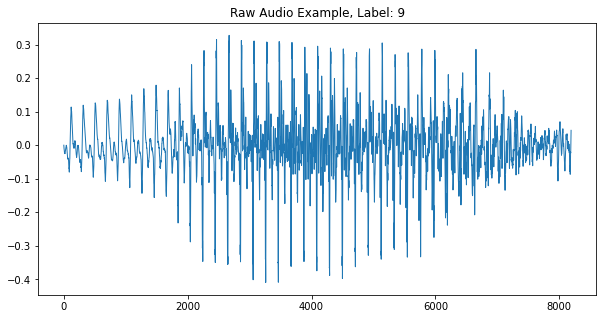

In [31]:
y, sr = librosa.load(audio_files[150]) # load the audio file usig 'librosa'
if len(y)> 0: 
  y, _ = librosa.effects.trim(y, top_db = 10) # trims the silence from audio. 
  # Without this trim, everythin will work fine. The plot reveals the effect of the trim. Feel free to run with and witout trimming. 
  # Also try with different top_db value to understand the effect of trim clearly
print(y.shape)
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title=f'Raw Audio Example, Label: {labels[150]}',)
plt.show()

In [11]:
# get mel spectrogram from audio
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

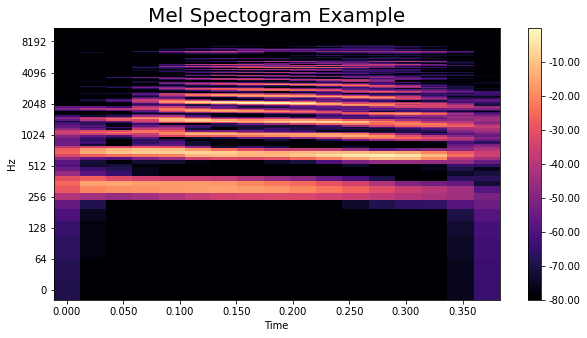

In [12]:
# Display the mel spectogram
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [13]:
S_db_mel.shape, S_db_mel 

((256, 17),
 array([[-69.08515 , -80.      , -80.      , ..., -80.      , -75.73039 ,
         -64.28063 ],
        [-68.16722 , -80.      , -80.      , ..., -80.      , -75.51695 ,
         -63.93319 ],
        [-66.567276, -77.67438 , -80.      , ..., -80.      , -74.12339 ,
         -63.181194],
        ...,
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ]], dtype=float32))

# Pre process the audio

In [14]:
# target_length = 10000 is used to make a fixed length audio data. The fixed length is important. 
# Without fixing the length, the mel_spec will give different shape for different length audio which will make problem to train the model. 
# Because the NN models expect a fixed shaped input 
# It is not a fixed value. I have used 10000,you can try with different values. If use different value, check the output shape from mel spec.

target_length = 10000 
def process_audio(file):
  y, sr = librosa.load(file) # load the audio
  if len(y)> 0: 
    y, _ = librosa.effects.trim(y, top_db = 10) # trim the audio to remove silence and the part where there was relatively low sound 

  # Trim if audio length > target_length 
  if len(y) > target_length: 
      y = y[0:0+target_length] # keep untill target length 
      
  #Else pad blanks if shorter 
  else: 
      padding = target_length - len(y)
      offset = padding // 2
      y = np.pad(y, (offset, target_length - len(y) - offset), mode = 'constant') # pad to target length 
  
  # get melspectrogram
  S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128,)
  S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

  return S_db_mel

In [15]:
# one hot encode labels. 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
y = np.array(labels).reshape(-1,1)
encoder.fit(y)
y= encoder.transform(y).toarray()
print(y[:5])

# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(audio_files, y, test_size=0.2, random_state=42)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [25]:
# Custom batch Data generator

class TrainDataSequence(tf.keras.utils.Sequence):

  def __init__(self, x = X_train, y = y_train,  batch_size = 32):
    self.x, self.y = x, y
    self.batch_size = batch_size


  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) *
    self.batch_size]

    batch_y = self.y[idx * self.batch_size:(idx + 1) *
    self.batch_size]

    X = []
    Y = []
    for indx, audio in enumerate(batch_x):
      mel_spec = process_audio(audio) 
      # print("mel shape: ", mel_spec.shape) # remove the firt '#' to check the mel outut spectogram shape
      X.append(mel_spec)
      Y.append(batch_y[indx])

    return np.array(X), np.array(Y)


In [26]:
class TestDataSequence(tf.keras.utils.Sequence):
  def __init__(self, x =X_test, y = y_test,  batch_size = 32):
    self.x, self.y = x, y
    self.batch_size = batch_size


  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) *
    self.batch_size]

    batch_y = self.y[idx * self.batch_size:(idx + 1) *
    self.batch_size]

    X = []
    Y = []
    for indx, audio in enumerate(batch_x):
      mel_spec = process_audio(audio) 
      X.append(mel_spec)
      Y.append(batch_y[indx])

    return np.array(X), np.array(Y)

In [27]:
train_sequence =  TrainDataSequence()
test_sequence = TestDataSequence()
# print(*train_sequence)

# CNN Model


In [28]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 2), activation='relu', input_shape=(128,20,1),))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(16, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

In [29]:
print("[INFO] compiling model...")
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics="accuracy")
model.summary()

[INFO] compiling model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 19, 32)       224       
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 17, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 8, 64)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 6, 32)         18464     
                                                                 
 conv2d_7 (Conv2D)           (None, 59, 5, 16)         2064      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 1, 16)        0         
 2D)                        

In [30]:
history = model.fit(train_sequence, validation_data = test_sequence, epochs = 30, verbose=1)

Epoch 1/30
75/75 [==============================] - 34s 402ms/step - loss: 2.0695 - accuracy: 0.2450 - val_loss: 1.6240 - val_accuracy: 0.3433
Epoch 2/30
75/75 [==============================] - 35s 466ms/step - loss: 1.4514 - accuracy: 0.4196 - val_loss: 0.9865 - val_accuracy: 0.6417
Epoch 3/30
75/75 [==============================] - 36s 481ms/step - loss: 1.1216 - accuracy: 0.5658 - val_loss: 0.8717 - val_accuracy: 0.6933
Epoch 4/30
75/75 [==============================] - 30s 408ms/step - loss: 0.9340 - accuracy: 0.6408 - val_loss: 0.7068 - val_accuracy: 0.7367
Epoch 5/30
75/75 [==============================] - 44s 591ms/step - loss: 0.8231 - accuracy: 0.7004 - val_loss: 0.6480 - val_accuracy: 0.8050
Epoch 6/30
75/75 [==============================] - 38s 511ms/step - loss: 0.7165 - accuracy: 0.7254 - val_loss: 0.3989 - val_accuracy: 0.8933
Epoch 7/30
75/75 [==============================] - 42s 561ms/step - loss: 0.6344 - accuracy: 0.7713 - val_loss: 0.4002 - val_accuracy: 0.8683

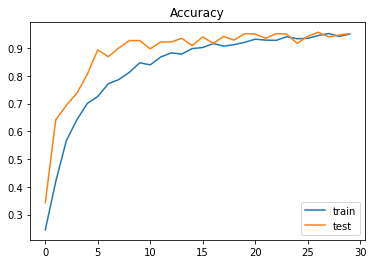

In [34]:
# epoch vs Accuracy graph
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

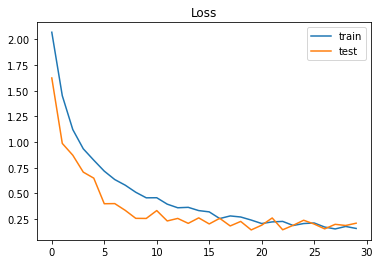

In [32]:
# epoch vs loss graph
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()